# CMA/ES - GORGO 11 SEQUENTIAL - 1th try: LL92, lapse + sigma_base


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [4]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11sequential_ll92_1try_Mratiosigmaxsigmabaselinelapseratealpha_repetitions3_080817
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-<module>-0a2c98a7-bbf6-47ef-9b22-e722638c6732.npy').item()

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_gorgo11sequential_ll92_1try_Mratiosigmaxsigmabaselinelapseratealpha_repetitions3_080817


In [6]:
dataio = DataIO(label='cmaes_gorgo11seq', 
                calling_function='', 
                output_folder='./outputs/')

=== FileIO ready: ./outputs/cmaes_gorgo11seq-5a015d1a-db41-49b5-965d-e02949d79275 ===


In [7]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [8]:
parameter_names_sorted

['M', 'alpha', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [9]:
metric = 'dist_nll92'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])

In [10]:
# Fix M and ratio_conj
M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
df_all_fits.loc[:, 'M'] = M_corrected
df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [11]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

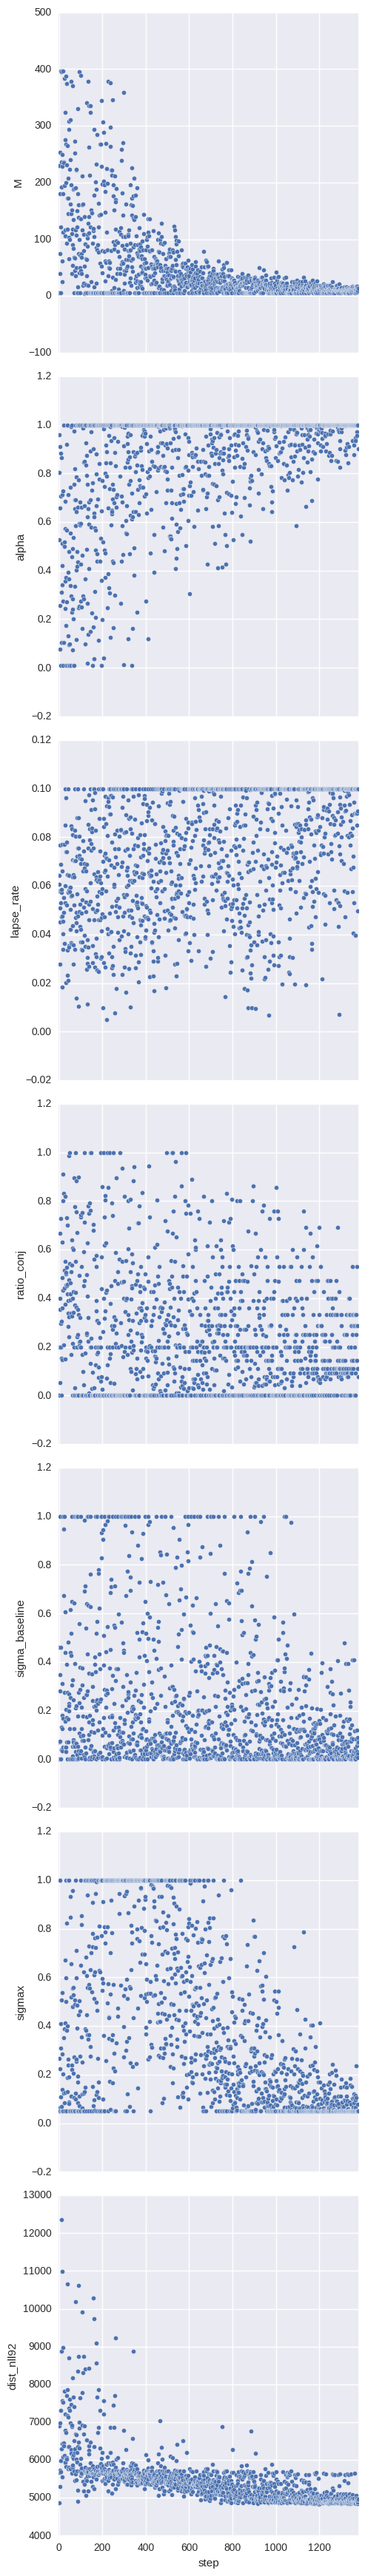

In [12]:
# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted + [metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))
# dataio.save_current_figure('cmaes_traj_{label}_{unique_id}.pdf')

# Check parameters effects
# sns.pairplot(df_best_fits,
#              x_vars=parameter_names_sorted,
#              y_vars=[metric],
#             )



In [13]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 1000]
# result_to_color = np.array(df_cmaes_traj['dist_nll92'])
result_to_color = np.array(df_cmaes_traj['step'])
# result_to_color = np.log(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj['M'],
        y = df_cmaes_traj['lapse_rate'],
        z = df_cmaes_traj['sigma_baseline'],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title='M',
        ),
        yaxis=go.YAxis(
            title='lapse_rate',
        ),
        zaxis=go.ZAxis(
            title='sigma_baseline',
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [14]:
df_bestparams = df_best_fits.sort_values(by='step', ascending=False).head(20).median()
df_bestparams

step              1369.500000
dist_nll92        4889.513201
M                   12.000000
alpha                1.000000
lapse_rate           0.100000
ratio_conj           0.171429
sigma_baseline       0.038515
sigmax               0.050000
dtype: float64

In [16]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_sequential_allmetrics',
                             inference_method='none',
                             experiment_id='gorgo11_sequential',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             alpha=1.,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1500, 
                             filter_datapoints_selection='random'
                             )

experiment_parameters.update(df_bestparams)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']

Arguments: ['-f', '/run/user/5201/jupyter/kernel-a9e4b760-91e8-451e-bd26-91c3c8092f44.json']

        Given a single experiment_id, will run the model on all (T, trecall) in the experimental data.
        Most likely you want gorgo11_seq.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperiment_sequential_allmetrics
{'M_layer_one': 400, 'code_type': 'mixed', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normali

-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-33.908643758
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 5 nitems, 2 trecall, 19 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 19, 5 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 2
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-25.9344504733
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 5 nitems, 3 trecall, 19 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 19, 5 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 3
Computing normalisation

-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-28.9528113334
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 4 nitems, 2 trecall, 17 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 17, 4 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 2
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-29.5558438277
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 4 nitems, 3 trecall, 17 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 17, 4 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 3
Computing normalisatio

-> init theta, feature 1 cued, time 2
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-29.2066400998
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 3 nitems, 1 trecall, 17 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 17, 3 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-23.8060692107
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 3 nitems, 2 trecall, 17 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 17, 3 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 2
Computing normalisatio

-> init theta, feature 1 cued, time 6
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-26.0579297569
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...
{}


Subject 4, rep 1/1 | 33.33%, 2m36s left - 08.08 18:56
reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Gorgoraptis_2011/em_gorgo_seq_basicmodel.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Gorgoraptis_2011/collapsed_em_gorgo_seq_new.pickle
FitExperimentSequentialSubjectAll: subject 4, gorgo11_sequential dataset. 19 datapoints

>>> Setting up 1 nitems, 1 trecall, 19 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 19, 1 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued,

-> init theta, feature 1 cued, time 2
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-32.0019378023
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 3 trecall, 19 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 19, 6 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 3
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-32.8367623288
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 4 trecall, 19 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 19, 6 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 4
Computing normalisatio

-> init theta, feature 1 cued, time 3
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-33.8417594957
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 5 nitems, 4 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 5 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 4
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-29.0883330087
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 5 nitems, 5 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 5 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 5
Computing normalisatio

-> init theta, feature 1 cued, time 3
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-27.2125607367
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 4 nitems, 4 trecall, 18 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 18, 4 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 4
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-25.6126665845
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 5 nitems, 1 trecall, 18 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 18, 5 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisatio

-> init theta, feature 1 cued, time 2
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-28.0764824696
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 3 nitems, 3 trecall, 18 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 18, 3 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 3
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-25.6755707007
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 4 nitems, 1 trecall, 18 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 18, 4 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisatio

-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-36.6387215476
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 2 nitems, 1 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 2 items/times.
sigma_x 0.00279, sigma_y 5.57e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-22.6502012344
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 2 nitems, 2 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 2 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 2
Computing normalisatio

-> init theta, feature 1 cued, time 4
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-32.4891837695
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 5 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 6 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 5
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-32.1265585558
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 6 trecall, 16 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 16, 6 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 6
Computing normalisatio

-> init theta, feature 1 cued, time 5
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-38.2412375757
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 1 trecall, 20 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 20, 6 items/times.
sigma_x 0.00278, sigma_y 5.57e-07 sigma_baseline 0.00214 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-37.3875268051
>> Computing BIC...
Bic: K  4.0
>> Computing LL90/92/95/97...

>>> Setting up 6 nitems, 2 trecall, 20 datapoints
Create mixed network, R=2 autoset: 1
Population sizes: ratio: 0.17 conj: 2, feat: 10, autoset: 1
== DataGeneratorRfn ==
Size: 20, 6 items/times.
sigma_x 0.00279, sigma_y 5.58e-07 sigma_baseline 0.00215 renormalized: 1
-> init theta, feature 1 cued, time 2
Computing normalisatio

In [169]:
plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)

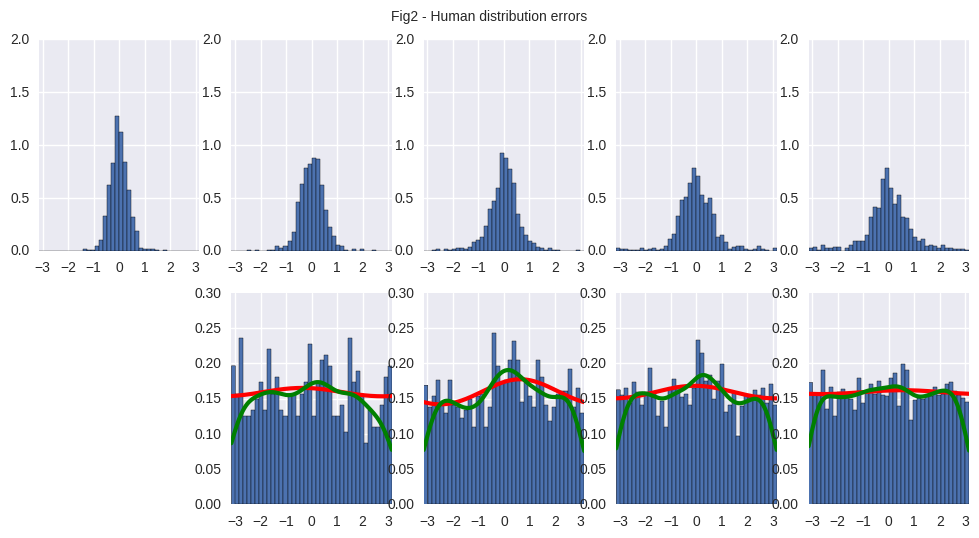

In [170]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()

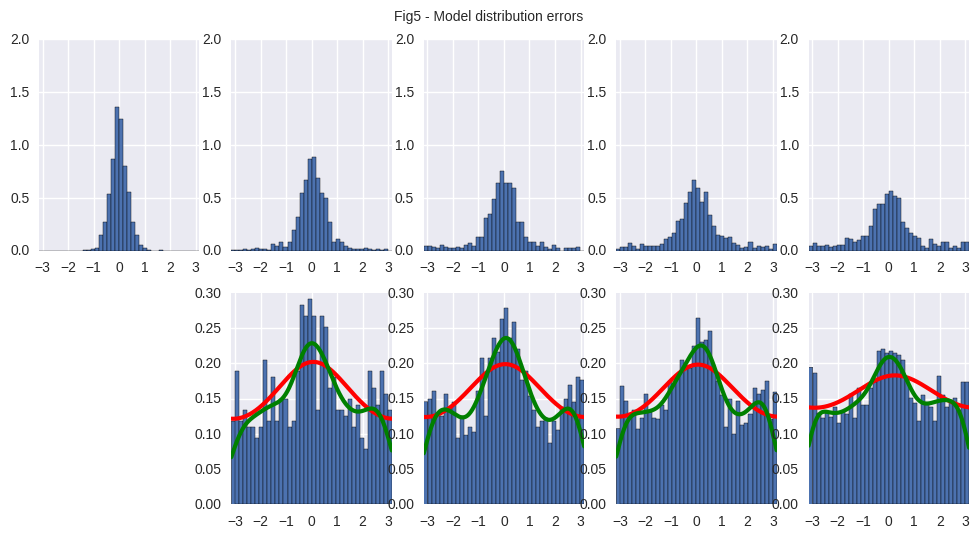

In [171]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()

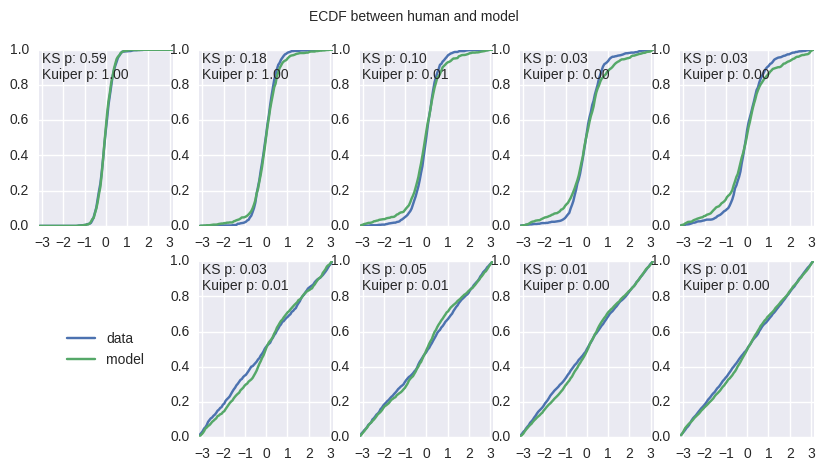

In [172]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((10, 5))

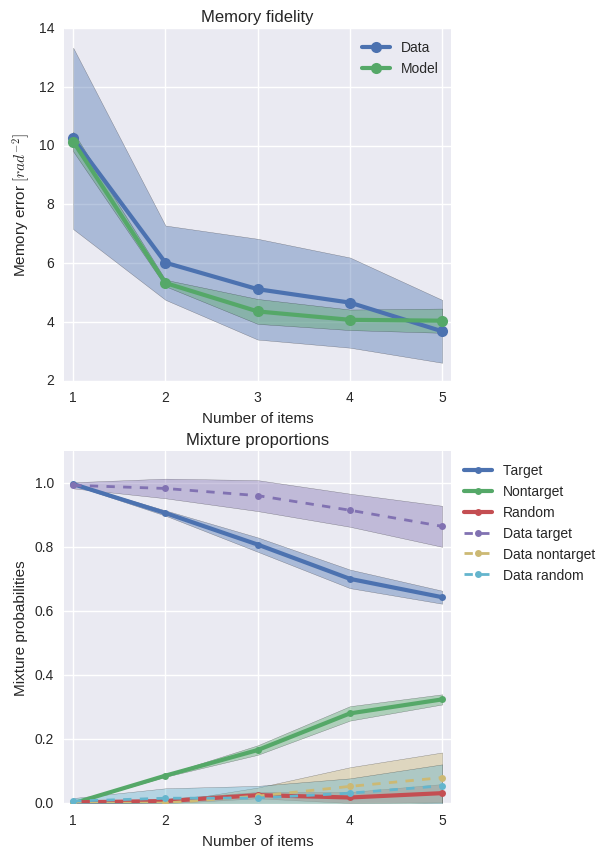

In [173]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Discussion:

Well, super different parameters from Bays09 for sure!

Finds parameters worst in LL90 than [random sweep](../fitexperiment_allt_new_10_2015/notebook_LLlapse_gorgo11_random_fitexperimentallt_sigmaxMratiolapserate_301015.ipynb), but the mixture models are better, at least on the memory fidelity.

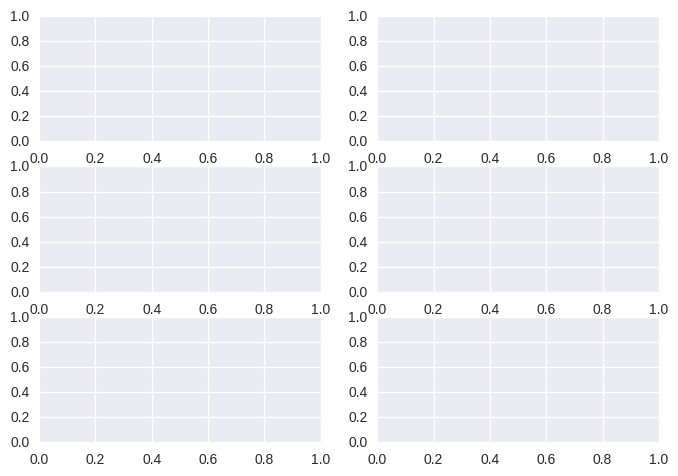

In [22]:
f, axes = plt.subplots(ncols=2, nrows=3)

In [23]:
axes.shape

(3, 2)